# <div style="text-align:center; background: #3d4140; padding: 7px; border-radius:10px 10px; font-size: 1.5em; color: #cfd7d0; cursor: pointer;font-family: cursive;"><b> 1. Introduction </b></div>

In this notebook, we compare the performance of three sentiment analysis models trained on the same IMDB dataset:

- **Logistic Regression** (with TF-IDF features)
- **BiLSTM** (with Word2Vec embeddings)
- **DeBERTa-v3-small** (a transformer-based model)

These models represent two generations of NLP techniques:
- 🧠 Traditional ML & Deep Learning (LogReg, BiLSTM)
- 🤖 Modern Transformers (DeBERTa)

---

✅ **Goal of this notebook**  
To **analyze and compare the performance** of these models on the same test data using:

- Accuracy, F1-Score, Precision, and Recall  
- Confusion Matrices for error analysis  
- Visualizations for easier interpretation  
- A final summary comparison table  
- Key takeaways and conclusions

This comparison will help us answer:
- Which model performs best overall?
- Do transformers really outperform classic models in practice?
- What are the trade-offs between simplicity and power?

Let’s begin by loading the saved predictions for each model.


![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*VHiPquX7PHDvuC-y5w6wSg.png)

# <div style="text-align:center; background: #3d4140; padding: 7px; border-radius:10px 10px; font-size: 1.5em; color: #cfd7d0; cursor: pointer;font-family: cursive;"><b> 2. Load Saved Predictions </b></div>

We load the predictions and probabilities that were saved in the previous notebooks:

- `logistic_preds.csv` from the Logistic Regression model
- `bilstm_preds.csv` from the BiLSTM model
- `deberta_preds.csv` from the DeBERTa transformer model

Each file contains:
- The original review
- The true sentiment label
- The predicted label
- The prediction probabilities for both classes

These files allow us to evaluate all models on the **same test data**, ensuring a fair and consistent comparison.


In [1]:
import pandas as pd
import numpy as np

# Load predictions from previous notebooks
logistic_df = pd.read_csv("/kaggle/input/nlp-with-imdb-classic-models-tf-idf-bilstm/logistic_preds.csv")
bilstm_df   = pd.read_csv("/kaggle/input/nlp-with-imdb-classic-models-tf-idf-bilstm/bilstm_preds.csv")
deberta_df  = pd.read_csv("/kaggle/input/nlp-with-imdb-transformers-deberta/deberta_preds.csv")

# Show a quick preview to confirm successful loading
print("Logistic Regression Predictions:")
display(logistic_df.head(2))

print("\nBiLSTM Predictions:")
display(bilstm_df.head(2))

print("\nDeBERTa Predictions:")
display(deberta_df.head(2))


Logistic Regression Predictions:


,review,true_label,predicted_label,prob_negative,prob_positive
0,"Yes, MTV there really is a way to market Daria...",0,0,0.60580,0.39420
1,The story of the bride fair is an amusing and ...,0,1,0.36554,0.63446



BiLSTM Predictions:


,review,true_label,predicted_label,prob_negative,prob_positive
0,"Yes, MTV there really is a way to market Daria...",0,0,0.789537,0.210463
1,The story of the bride fair is an amusing and ...,0,1,0.418455,0.581545



DeBERTa Predictions:


,review,true_label,predicted_label,prob_negative,prob_positive
0,"Yes, MTV there really is a way to market Daria...",0,1,0.019738,0.980262
1,The story of the bride fair is an amusing and ...,0,0,0.986726,0.013274


# <div style="text-align:center; background: #3d4140; padding: 7px; border-radius:10px 10px; font-size: 1.5em; color: #cfd7d0; cursor: pointer;font-family: cursive;"><b> 3. Evaluation </b></div>

In this section, we evaluate and compare the performance of the three models using both numerical metrics and visual tools.  
We begin with standard classification metrics, followed by confusion matrices and visualizations.

---

## 3.1 Accuracy, Precision, Recall, and F1-Score

We evaluate each model on the same test set using the following metrics:

- **Accuracy**: How often the model predicts correctly  
- **Precision**: How many predicted positives are actually correct  
- **Recall**: How many actual positives were correctly predicted  
- **F1-Score**: Harmonic mean of precision and recall — balances the two

These metrics give a well-rounded view of performance, especially in **imbalanced or real-world** datasets.

The table below compares the three models:
- Logistic Regression (TF-IDF)
- BiLSTM (Word2Vec)
- DeBERTa (Transformer)


In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    }

# Evaluate each model
logistic_scores = evaluate_metrics(logistic_df['true_label'], logistic_df['predicted_label'], "Logistic Regression")
bilstm_scores   = evaluate_metrics(bilstm_df['true_label'], bilstm_df['predicted_label'], "BiLSTM")
deberta_scores  = evaluate_metrics(deberta_df['true_label'], deberta_df['predicted_label'], "DeBERTa")

# Combine into a single DataFrame
import pandas as pd
scores_df = pd.DataFrame([logistic_scores, bilstm_scores, deberta_scores])
scores_df = scores_df.round(4)  # Round for cleaner display

# Display the results
scores_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.8692,0.8560,0.8878,0.8716
1,BiLSTM,0.8921,0.8923,0.8918,0.8921
2,DeBERTa,0.9518,0.9509,0.9528,0.9518


## 3.2 Confusion Matrix

Confusion matrices allow us to analyze the types of errors made by each model.  
Each matrix shows:

- **True Positives**: correctly predicted positive reviews
- **True Negatives**: correctly predicted negative reviews
- **False Positives**: predicted positive but actually negative
- **False Negatives**: predicted negative but actually positive

By visualizing these matrices, we can identify whether the model tends to favor one class over the other or has a balanced performance.

Let’s look at the confusion matrix for each model.


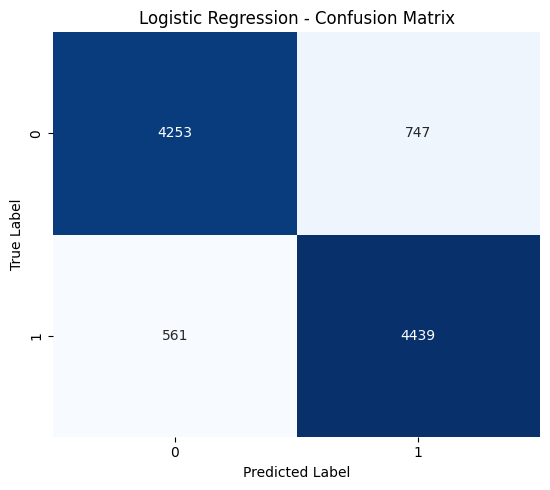

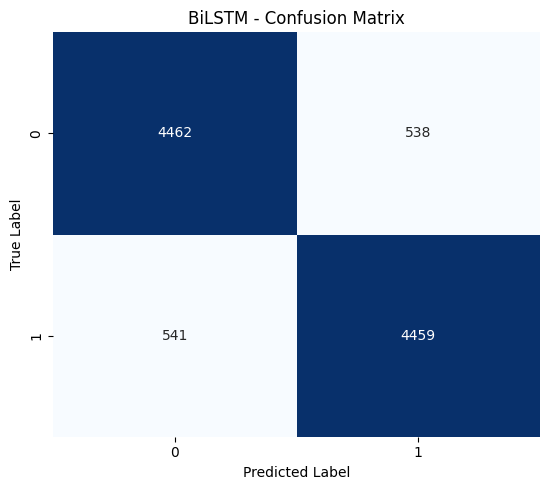

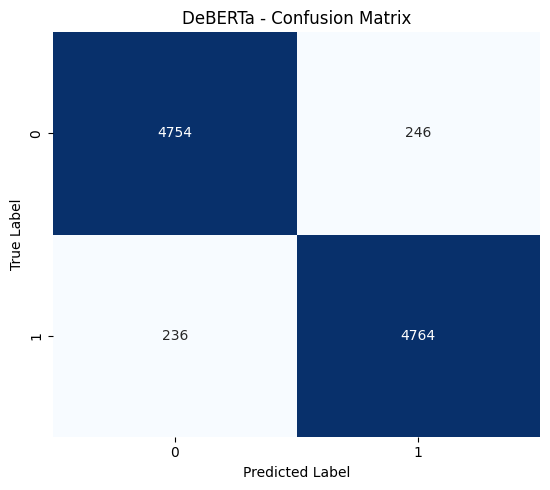

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5.6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Plot for all models
plot_confusion(logistic_df['true_label'], logistic_df['predicted_label'], "Logistic Regression")
print("=="*40)
plot_confusion(bilstm_df['true_label'], bilstm_df['predicted_label'], "BiLSTM")
print("=="*40)
plot_confusion(deberta_df['true_label'], deberta_df['predicted_label'], "DeBERTa")


# <div style="text-align:center; background: #3d4140; padding: 7px; border-radius:10px 10px; font-size: 1.5em; color: #cfd7d0; cursor: pointer;font-family: cursive;"><b> 4. Visual Comparison </b></div>

While numerical metrics are useful for measuring performance, visualizations make it easier to:

- Quickly compare models side by side  
- Spot strengths and weaknesses at a glance  
- Communicate results more effectively, especially in presentations or reports

In this section, we present visual comparisons of model performance to support our evaluation.


## 4.1 Bar Plot of Metrics

The bar plot below visually compares the performance of the three models  
across the four key evaluation metrics:

- Accuracy  
- Precision  
- Recall  
- F1-Score

This visualization makes it easier to spot which model consistently performs better,  
and where certain models may fall short in specific areas (e.g., precision vs recall).


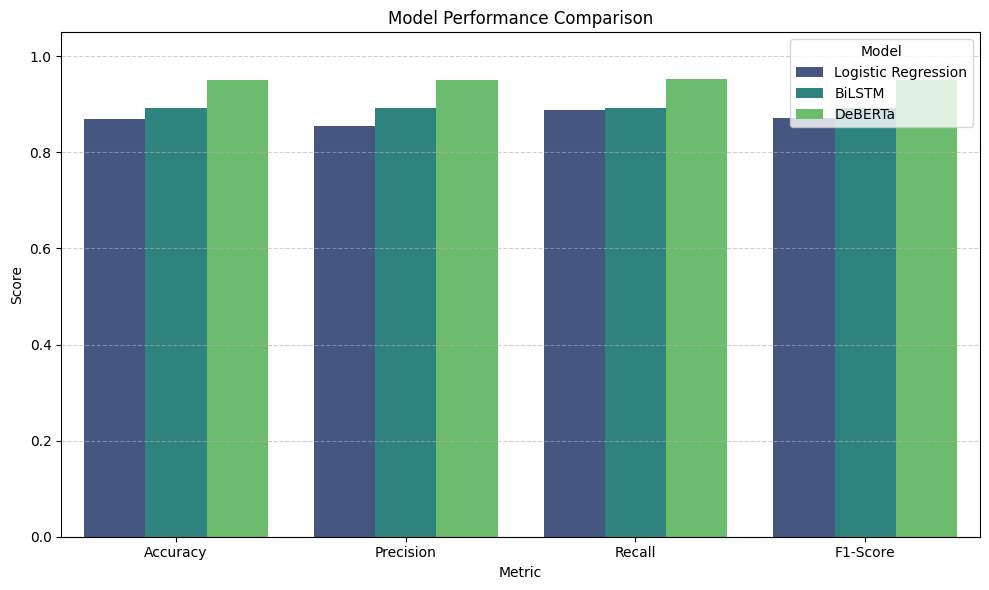

In [4]:
import matplotlib.pyplot as plt

# Melt the DataFrame to long format for easier plotting
melted_scores = scores_df.melt(id_vars="Model", 
                               value_vars=["Accuracy", "Precision", "Recall", "F1-Score"],
                               var_name="Metric", 
                               value_name="Score")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_scores, x="Metric", y="Score", hue="Model", palette="viridis")

plt.title("Model Performance Comparison")
plt.ylim(0.0, 1.05)
plt.legend(title="Model")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## 4.2 Metric Radar Plot

This radar chart (also known as a spider plot) shows all four key metrics for each model in one visual.

- A wider and more rounded shape indicates better overall performance.
- DeBERTa clearly dominates across all axes, showing its superiority.
- BiLSTM is balanced and strong, especially compared to Logistic Regression.


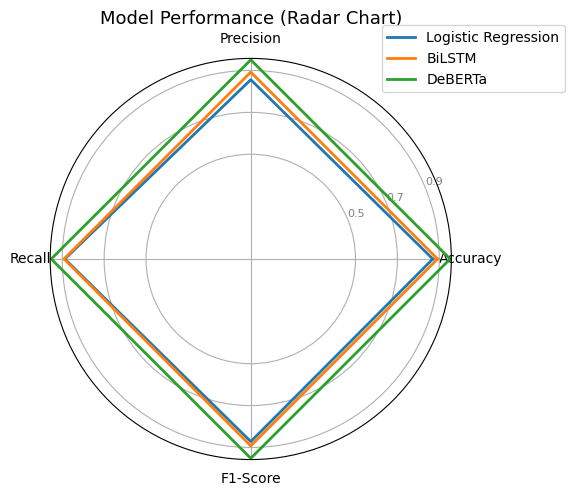

In [5]:
import numpy as np

# Define the metrics and models
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
models = scores_df['Model'].tolist()
num_vars = len(labels)

# Prepare angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Create radar plot
plt.figure(figsize=(6, 6))
for i in range(len(scores_df)):
    values = scores_df.iloc[i, 1:].tolist()
    values += values[:1]  # Complete the loop
    plt.polar(angles, values, label=models[i], linewidth=2)

# Add labels
plt.xticks(angles[:-1], labels)
plt.yticks([0.5, 0.7, 0.9], ["0.5", "0.7", "0.9"], color="grey", size=8)
plt.title("Model Performance (Radar Chart)", size=13)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


# <div style="text-align:center; background: #3d4140; padding: 7px; border-radius:10px 10px; font-size: 1.5em; color: #cfd7d0; cursor: pointer;font-family: cursive;"><b> 5. Summary Table </b></div>


The table below summarizes the core evaluation metrics for all three models:

| Model               | Accuracy | Precision | Recall | F1-Score |
|--------------------|----------|-----------|--------|----------|
| Logistic Regression | 0.8692   | 0.8560    | 0.8878 | 0.8716   |
| BiLSTM              | 0.8921   | 0.8923    | 0.8918 | 0.8921   |
| DeBERTa             | 0.9518   | 0.9509    | 0.9528 | 0.9518   |

---

### 🔍 Key Insights:

- **DeBERTa** significantly outperforms both classical models across all metrics, confirming the power of transformer-based architectures.
- **BiLSTM** offers a strong balance between performance and complexity — a good option when resources are limited but you need more than basic models.
- **Logistic Regression**, despite being the simplest, still performs reasonably well. It's a great baseline, but lacks deep understanding of context.

This summary highlights the **trade-offs between simplicity and accuracy**, and helps guide model selection based on project needs.


# <div style="text-align:center; background: #3d4140; padding: 7px; border-radius:10px 10px; font-size: 1.5em; color: #cfd7d0; cursor: pointer;font-family: cursive;"><b> 6. Final Thoughts </b></div>

This comparison highlights the evolution of Natural Language Processing (NLP) models —  
from traditional linear models, through deep learning, to the state-of-the-art transformer-based architectures.

### 🔍 Key Takeaways:

- **Logistic Regression** is simple, fast, and surprisingly effective for baseline performance.  
- **BiLSTM** captures sequential dependencies and provides better understanding than linear models.  
- **DeBERTa**, a transformer model, outperforms both by modeling deep contextual information.

While transformers offer the best performance, they require more compute power —  
so model selection depends on both **accuracy needs** and **hardware limits**.

---

### 📘 Notebooks Used in This Comparison:

- 🔹 [NLP with IMDB: Classic Models (TF-IDF + BiLSTM)](https://www.kaggle.com/code/ahmedgaitani/nlp-with-imdb-classic-models-tf-idf-bilstm)  
- 🔹 [NLP with IMDB: Transformers (DeBERTa)](https://www.kaggle.com/code/ahmedgaitani/nlp-with-imdb-transformers-deberta)

These notebooks contain full implementation details for each model from preprocessing to prediction output.

✅ This comparison shows that combining classic and modern tools gives flexibility to fit any project need.
